## Exploratory Data Analysis (EDA) for H&M Dataset

### Import necessary modules

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

### Download and unzip the datasets

In [2]:
!wget -N https://szdataset.s3.us-east-2.amazonaws.com/531/hm_kaggle_data.zip -P "/content"
with zipfile.ZipFile("hm_kaggle_data.zip","r") as zip_ref:
    zip_ref.extractall(".")

--2023-05-04 15:29:43--  https://szdataset.s3.us-east-2.amazonaws.com/531/hm_kaggle_data.zip
Resolving szdataset.s3.us-east-2.amazonaws.com (szdataset.s3.us-east-2.amazonaws.com)... 52.219.88.104
Connecting to szdataset.s3.us-east-2.amazonaws.com (szdataset.s3.us-east-2.amazonaws.com)|52.219.88.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 609579548 (581M) [application/zip]
Saving to: ‘/content/hm_kaggle_data.zip’

hm_kaggle_data.zip  100%[===================>] 581.34M  63.8MB/s    in 9.0s    

2023-05-04 15:29:52 (64.6 MB/s) - ‘/content/hm_kaggle_data.zip’ saved [609579548/609579548]



### Read in dataset files

#### Read in item_ids csv files (added before)

In [3]:
item_ids_df = pd.read_csv('./data/item_ids.csv')
item_ids_df.head()

,itemid,new_id
0,304766008,0
1,662916002,1
2,740909001,2
3,666382002,3
4,583534018,4


#### Read in transactions_train csv file

In [4]:
transactions_train_df = pd.read_csv('./data/transactions_train.csv')
transactions_train_df.columns = ['t_dat', 'customer_id', 'itemid', 'price', 'sales_channel_id'] # Rename article_id to itemid
assert(len(transactions_train_df)== 31788324)
transactions_train_df.head()

,t_dat,customer_id,itemid,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


### Feature Engineering & Exploration

#### Item Feature 1: Average price of item (article)

For fashion articles or other articles as well, the price of each article is always one of the most important factors for users to consider; the cheaper the item it is with ensuring the quality, the more likely will the item being chosen by customers. Also, people who prefer to choose to buy articles with similar price level. Therefore, using price of items (articles) would be a good choice for the recommendation system.

The detailed instructions and code snippets of extracting price of items based on events as the feature are shown below:

In [5]:
# Calculate the average price of each item
item_price_avg = transactions_train_df.groupby('itemid')['price'].mean()

# Left join based on the itemid
result_df = item_ids_df.merge(item_price_avg, on='itemid', how='left')

# Fill NA values with 0
result_df.fillna(0, inplace=True)

#### Item Feature 2: Total revenue of item (article)

Besides prices, the total revenue of the article can also be an important thing. This might look a little bit not straightforward, since revenues are usually the thing that the article company or sellers would consider; the key is that the total revenue also reflects the popularity of the articles among costumers, and costumers will tend to buy more popular/best seller articles among their choices. Therefore, using total revenue of fashion article as an item feature can also contribute to the recommendation system of it.

The detailed instructions and code snippets of extracting total revenues for each article as the feature are shown below:

In [6]:
# Compute the total revenue by summing all the prices
item_revenue = transactions_train_df.groupby('itemid')['price'].sum()

# Left join based on the itemid
result_df = result_df.merge(item_revenue, on='itemid', how='left')

# Fill NA values with 0
result_df.fillna(0, inplace=True)

# Rename prices to their corresponding meaning
result_df.columns = ['itemid', 'new_id', 'price_avg', 'revenue']

#### Exploration

To ensure that each feature can effectively contribute to the final recommendation, all numerical features must ideally be independent to each other, or it will result in the collinearity problem that negatively impacts the recommendation model. Therefore, we perform a correlation check on all numerical features to see if there exists highly correlated features; if so, these features contains redundant information and we choose to remove some of them to ensure accuarcy.

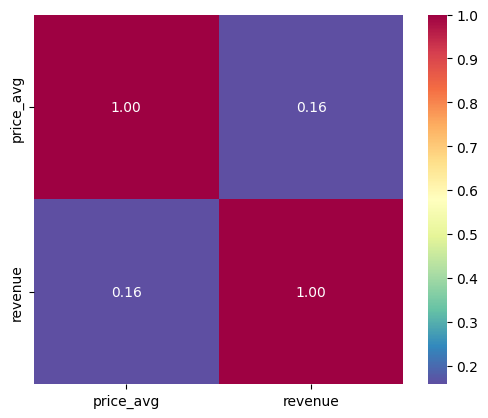

In [7]:
df = result_df[['price_avg', 'revenue']] # item_id and new_id are both categorical features
corrmat = df.corr()
hm = sns.heatmap(corrmat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=df.columns, 
                 xticklabels=df.columns, 
                 cmap="Spectral_r")
plt.show()

From the correlation matrix heat map above, we can figure out that there are only super weak correlation between the two features **average of price feature** and **item total revenue feature**. Therefore, we can choose to include all these features for our recommendation model training process.

### Browse & save the pre-processed data

In [8]:
result_df.head(10)

,itemid,new_id,price_avg,revenue
0,304766008,0,0.013231,8.706034
1,662916002,1,0.021352,4.291712
2,740909001,2,0.030766,9.752712
3,666382002,3,0.020301,24.462288
4,583534018,4,0.016463,7.902237
5,583534009,5,0.016336,52.616695
6,665532003,6,0.095647,11.668983
7,399256001,7,0.016138,326.665271
8,519583033,8,0.027637,106.068983
9,699667001,9,0.038638,2.395559


The first 10 rows of the pre-processed data is shown above, and the data can be saved into csv format by executing the code below.

In [9]:
result_df.to_csv('./hm_item_features.csv', index=False)